In [18]:

import matplotlib.pyplot as plt

[]

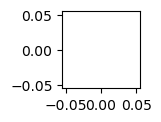

In [19]:
plt.figure(figsize=(1, 1)) 
plt.plot()

In [20]:
from PEQ import ParametricEQ, parametric_eq, biqaud, freqz
from scipy.signal import freqz, iirfilter
import numpy as np
import IPython.display as ipd

import torchaudio
import torch

In [21]:
def listen(y,rate):
    y_numpy = y.detach().numpy()[0]
    ipd.display(ipd.Audio(y_numpy, rate=rate))

def show(y, rate, first_sample = 500):
    # Convert y to numpy array and select the first channel if it's multichannel
    y_numpy = y.detach().numpy()[0,0]

    # Plot the first 100 samples
    plt.figure(figsize=(15, 4))
    
    # Creating subplot for time-domain signal
    plt.subplot(1, 2, 1)
    plt.plot(y_numpy[:first_sample])
    plt.title("First 100 samples")
    plt.xlabel("Sample number")
    plt.ylabel("Amplitude")

    # Calculating FFT of the signal
    fft_result = np.fft.fft(y_numpy)
    freq = np.fft.fftfreq(len(y_numpy), d=1/rate)

    # Creating subplot for frequency-domain signal
    plt.subplot(1, 2, 2)
    plt.semilogx(freq[:len(freq)//2], np.abs(fft_result)[:len(freq)//2])
    plt.title("FFT of the signal")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")

    plt.tight_layout()
    plt.show()

In [22]:
from scipy.signal import freqz, iirfilter
from typing import List

def freqz(b, a, n_fft: int = 512):

    B = torch.fft.rfft(b, n_fft)
    A = torch.fft.rfft(a, n_fft)

    H = B / A

    return H


def approx_iir_filter_cascade_H(
    b_s: List[torch.Tensor],
    a_s: List[torch.Tensor],
    x: torch.Tensor,
):
    """Apply a cascade of IIR filters.

    Args:
        b (list[Tensor]): List of tensors of shape (3)
        a (list[Tensor]): List of tensors of (3)
        x (torch.Tensor): 1d Tensor.
    """

    if len(b_s) != len(a_s):
        raise RuntimeError(
            f"Must have same number of coefficients. Got b: {len(b_s)} and a: {len(a_s)}."
        )

    # round up to nearest power of 2 for FFT
    # n_fft = 2 ** math.ceil(math.log2(x.shape[-1] + x.shape[-1] - 1))
    n_fft = 2 ** torch.ceil(torch.log2(torch.tensor(x.shape[-1] + x.shape[-1] - 1)))
    n_fft = n_fft.int()

    # this could be done in parallel
    b = torch.stack(b_s, dim=0).type_as(x)
    a = torch.stack(a_s, dim=0).type_as(x)

    H = freqz(b, a, n_fft=n_fft)
    H = torch.prod(H, dim=0).view(-1)

    return H


def parametric_eq_freq(
    x: torch.Tensor,
    sample_rate: float,
    low_shelf_gain_dB: torch.Tensor,
    low_shelf_cutoff_freq: torch.Tensor,
    low_shelf_q_factor: torch.Tensor,
    first_band_gain_dB: torch.Tensor,
    first_band_cutoff_freq: torch.Tensor,
    first_band_q_factor: torch.Tensor,
    second_band_gain_dB: torch.Tensor,
    second_band_cutoff_freq: torch.Tensor,
    second_band_q_factor: torch.Tensor,
    third_band_gain_dB: torch.Tensor,
    third_band_cutoff_freq: torch.Tensor,
    third_band_q_factor: torch.Tensor,
    fourth_band_gain_dB: torch.Tensor,
    fourth_band_cutoff_freq: torch.Tensor,
    fourth_band_q_factor: torch.Tensor,
    high_shelf_gain_dB: torch.Tensor,
    high_shelf_cutoff_freq: torch.Tensor,
    high_shelf_q_factor: torch.Tensor,
):
    """Six-band parametric EQ.

    Low-shelf -> Band 1 -> Band 2 -> Band 3 -> Band 4 -> High-shelf

    Args:
        x (torch.Tensor): 1d signal.


    """
    a_s, b_s = [], []
    #print(f"autodiff peq fs = {sample_rate}")

    # -------- apply low-shelf filter --------
    b, a = biqaud(
        low_shelf_gain_dB,
        low_shelf_cutoff_freq,
        low_shelf_q_factor,
        sample_rate,
        "low_shelf",
    )
    b_s.append(b)
    a_s.append(a)

    # -------- apply first-band peaking filter --------
    b, a = biqaud(
        first_band_gain_dB,
        first_band_cutoff_freq,
        first_band_q_factor,
        sample_rate,
        "peaking",
    )
    b_s.append(b)
    a_s.append(a)

    # -------- apply second-band peaking filter --------
    b, a = biqaud(
        second_band_gain_dB,
        second_band_cutoff_freq,
        second_band_q_factor,
        sample_rate,
        "peaking",
    )
    b_s.append(b)
    a_s.append(a)

    # -------- apply third-band peaking filter --------
    b, a = biqaud(
        third_band_gain_dB,
        third_band_cutoff_freq,
        third_band_q_factor,
        sample_rate,
        "peaking",
    )
    b_s.append(b)
    a_s.append(a)

    # -------- apply fourth-band peaking filter --------
    b, a = biqaud(
        fourth_band_gain_dB,
        fourth_band_cutoff_freq,
        fourth_band_q_factor,
        sample_rate,
        "peaking",
    )
    b_s.append(b)
    a_s.append(a)

    # -------- apply high-shelf filter --------
    b, a = biqaud(
        high_shelf_gain_dB,
        high_shelf_cutoff_freq,
        high_shelf_q_factor,
        sample_rate,
        "high_shelf",
    )
    b_s.append(b)
    a_s.append(a)
    
    H = approx_iir_filter_cascade_H(b_s, a_s, x.view(-1))
        
    return H

[]

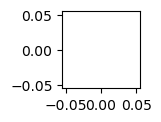

In [23]:
plt.figure(figsize=(1, 1)) 
plt.plot()

In [24]:
sample_rate = 44100

In [25]:
PEQ_0 = ParametricEQ(sample_rate)

In [26]:

def open_wav_as_torch(file_path, truncate = None):
    # Load WAV file
    waveform, sample_rate = torchaudio.load(file_path)
    # Convert to batch, channel, samples format (assuming single channel audio)
    waveform = torch.mean(waveform ,dim=0 ,keepdim= True)
    waveform = waveform.unsqueeze(0)  # Add a batch dimension
    if truncate is None:
        return waveform, sample_rate
    else:
        return waveform[...,:truncate], sample_rate

Sample rate 44100
x shape torch.Size([1, 1, 5000])


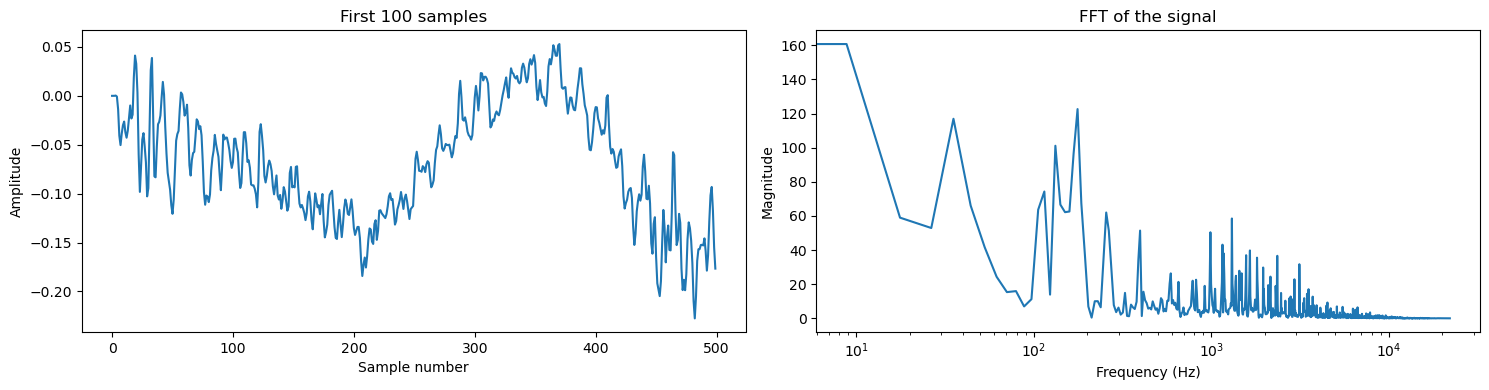

y shape torch.Size([1, 1, 5000])


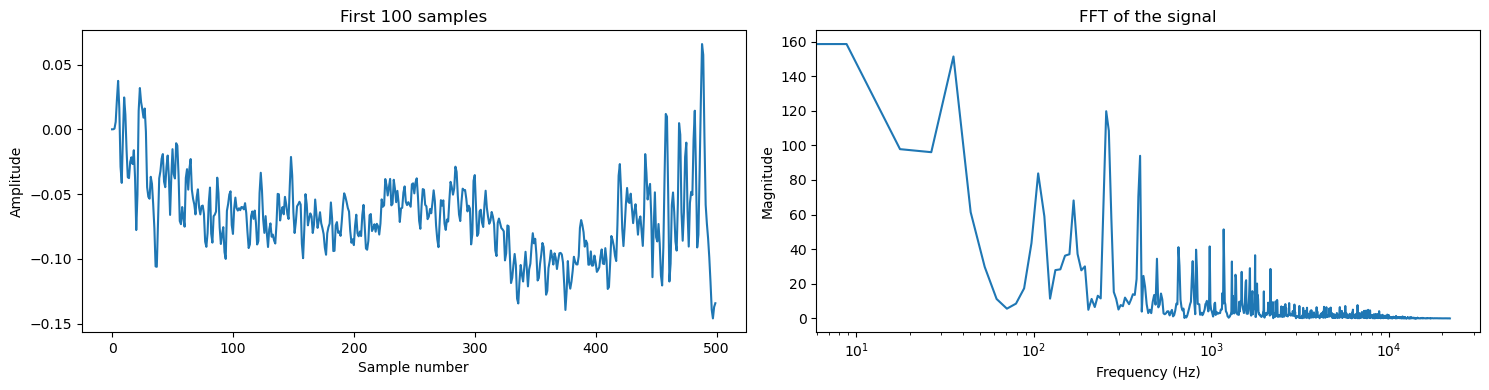

In [27]:
x, sr = open_wav_as_torch("Tests_Sounds/Git.wav",5000)
y, sr = open_wav_as_torch("Tests_Sounds/Git_PEQ.wav",5000)

print("Sample rate",sr)
print("x shape",x.shape)
listen(x,sr)
show(x,sr)
print("y shape",y.shape)
listen(y,sr)
show(y,sr)

In [28]:
p_0 = torch.tensor([port['default'] for port in PEQ_0.ports]).view(-1)
print(p_0)
print(PEQ_0.num_control_params,p_0.shape)
p_0 = PEQ_0.normalize_params(*p_0)
print(p_0)
p_0 = torch.log(p_0 / (1 - p_0))
print(p_0)

y_hat = PEQ_0(x,p_0,sample_rate)

print(y_hat.shape)

tensor([0.0000e+00, 1.0000e+02, 7.0700e-01, 0.0000e+00, 4.0000e+02, 7.0700e-01,
        0.0000e+00, 1.0000e+03, 7.0700e-01, 0.0000e+00, 4.0000e+03, 7.0700e-01,
        0.0000e+00, 8.0000e+03, 7.0700e-01, 0.0000e+00, 8.0000e+03, 7.0700e-01])
18 torch.Size([18])
tensor([[0.5000, 0.4444, 0.0613, 0.5000, 0.1111, 0.0613, 0.5000, 0.2105, 0.0613,
         0.5000, 0.3333, 0.0613, 0.5000, 0.5882, 0.0613, 0.5000, 0.5882, 0.0613]])
tensor([[ 0.0000, -0.2231, -2.7285,  0.0000, -2.0794, -2.7285,  0.0000, -1.3218,
         -2.7285,  0.0000, -0.6931, -2.7285,  0.0000,  0.3567, -2.7285,  0.0000,
          0.3567, -2.7285]])
torch.Size([1, 1, 5000])


In [29]:
import auraloss
import torch.nn as nn

class CombinedLoss(nn.Module):
    def __init__(self, alpha=100):
        super(CombinedLoss, self).__init__()
        self.frequ_loss = auraloss.freq.MultiResolutionSTFTLoss(
            fft_sizes=[32, 128, 512, 2048], #[32, 128, 512, 2048, 8192, 32768]
            hop_sizes=[16, 64, 256, 1024], #[16, 64, 256, 1024, 4096, 16384]
            win_lengths=[32, 128, 512, 2048], #[32, 128, 512, 2048, 8192, 32768]
            w_sc=0.0,
            w_phs=0.0,
            w_lin_mag=1.0,
            w_log_mag=1.0,
        )
        self.time_loss = nn.MSELoss()
        self.alpha = alpha

    def forward(self, y_hat, y):
        # Calculate frequency domain loss
        f_loss = self.frequ_loss(y_hat, y)
        # Calculate time domain loss
        t_loss = self.time_loss(y_hat, y)
        # Combine the losses
        total_loss = f_loss + self.alpha * t_loss
        return total_loss

In [30]:
# Assuming PEQ_0, x, and sample_rate are defined elsewhere

cfg = {
    'epochs': 50000,
    'lr': 0.011,
    'alpha': 100,
    'grad_clipping': 1
}

p = p_0.clone().detach().requires_grad_(True) 
loss_function = CombinedLoss(cfg['alpha'])
optimizer = torch.optim.Adam([p], lr=cfg['lr'])


# Lists to store metrics for plotting
losses = []
grads = [[] for _ in range(p.shape[1])]  # List of lists for each parameter's gradients
param_values = [[] for _ in range(p.shape[1])]  # List of lists for each parameter's values

for i in range(cfg['epochs']):
    
    optimizer.zero_grad()
    y_hat = PEQ_0(x, p, sample_rate)
    loss = loss_function(y_hat, y)
    loss.backward()
    optimizer.step()

    torch.nn.utils.clip_grad_norm_([p], max_norm=cfg['grad_clipping'])
    
    # Store loss
    losses.append(loss.item())
    
    # Store gradients and parameter values for each parameter
    for idx, param in enumerate(p.grad.view(-1)):
        grads[idx].append(param.item())
    for idx, param in enumerate(p.view(-1)):
        param_values[idx].append(param.item())
    
    print(f"{round(100*i/cfg['epochs'])} % {loss.item():.2e}", end="\r")

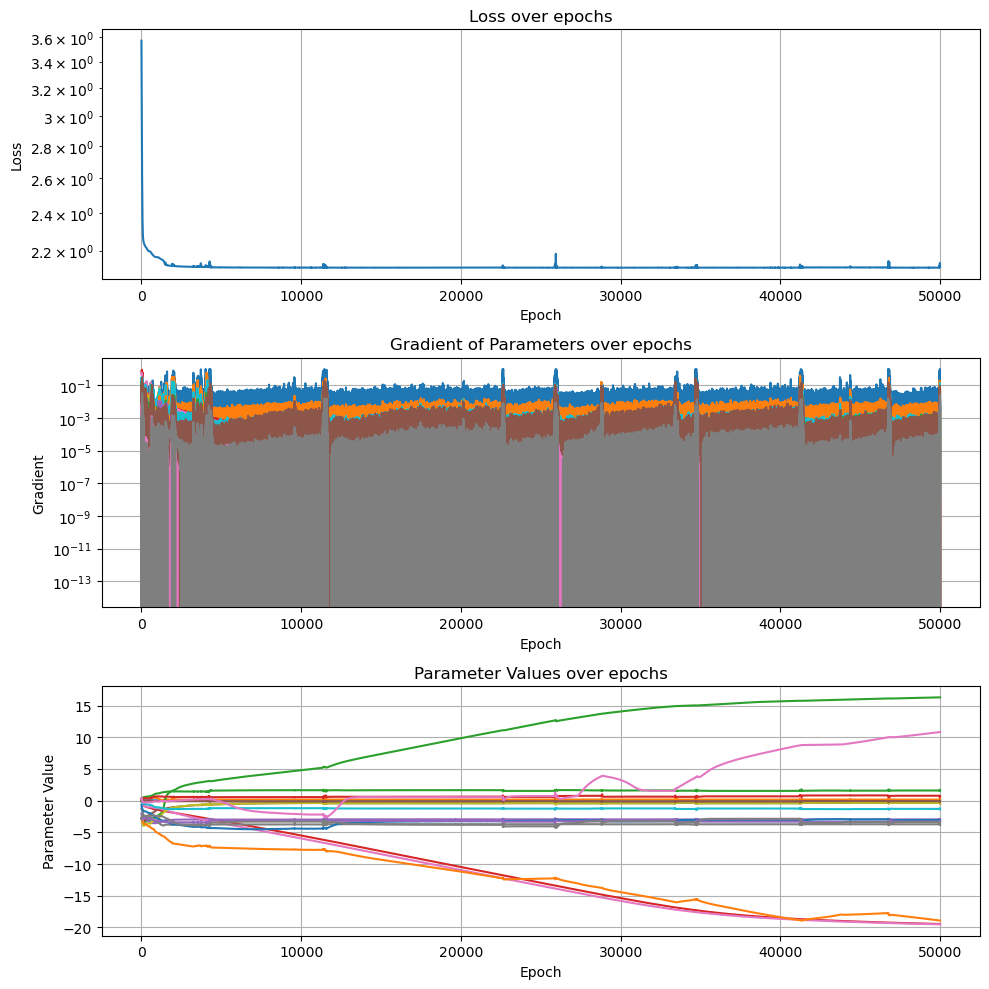

In [31]:
# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Loss plot
axs[0].semilogy(losses)
axs[0].set_title('Loss over epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid()

# Gradient plots for each parameter
for idx, grad_curve in enumerate(grads):
    axs[1].semilogy(grad_curve, label=f'Param {idx+1}')
axs[1].set_title('Gradient of Parameters over epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Gradient')
axs[1].grid()

# Parameter value plots for each parameter
for idx, param_curve in enumerate(param_values):
    axs[2].plot(param_curve, label=f'Param {idx+1}')
axs[2].set_title('Parameter Values over epochs')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Parameter Value')
axs[2].grid()

plt.tight_layout()
plt.show()

In [32]:
print(p)
PEQ_params = PEQ_0.denormalize_params(torch.sigmoid(p).view(-1))
y_hat = PEQ_0(x, p, sample_rate)

tensor([[  0.0857,   0.2051,  16.2822, -19.4649,  -3.0020,  -0.4930, -19.5228,
          -3.7762,  -0.4929,  -1.3855,  -3.2903, -18.9293,   1.6263,   0.6665,
          -3.3538,  -0.0422,  10.8314,  -3.5482]], requires_grad=True)


torch.Size([8193])


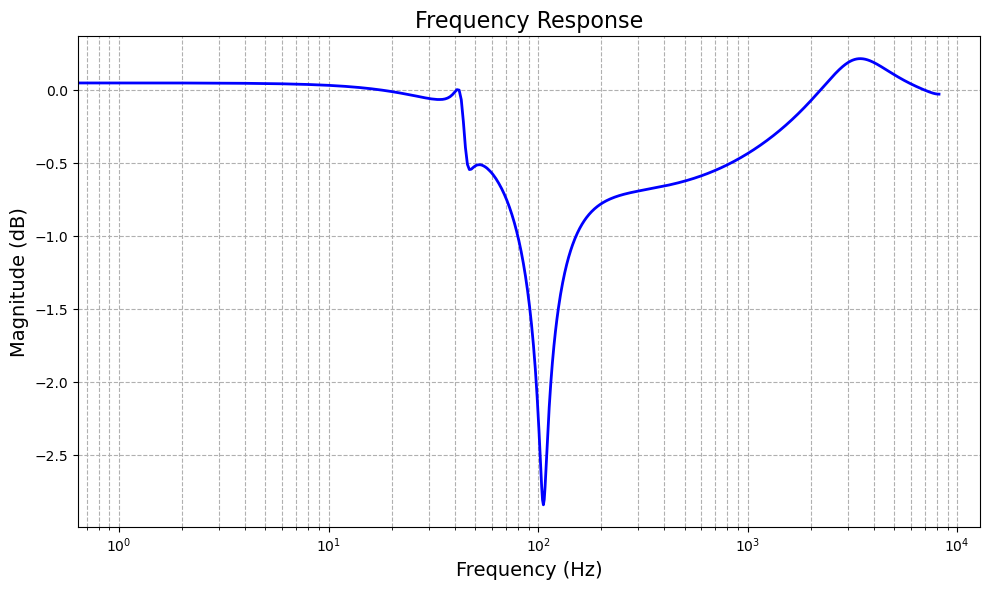

In [33]:
H = parametric_eq_freq(x,sample_rate,*tuple(PEQ_params))
print(H.shape)
plt.figure(figsize=(10, 6))  # Increase figure size
plt.semilogx(np.log10(np.abs(H.detach().numpy())), 'b-', linewidth=2)  # Increase line width and set color to blue
plt.title("Frequency Response", fontsize=16)  # Increase title font size
plt.xlabel("Frequency (Hz)", fontsize=14)  # Increase x-axis label font size
plt.ylabel("Magnitude (dB)", fontsize=14)  # Increase y-axis label font size and change to dB
plt.grid(True, which="both", ls="--")  # Add grid lines for both major and minor ticks
plt.tight_layout()  # Adjust layout to not overlap
plt.show()

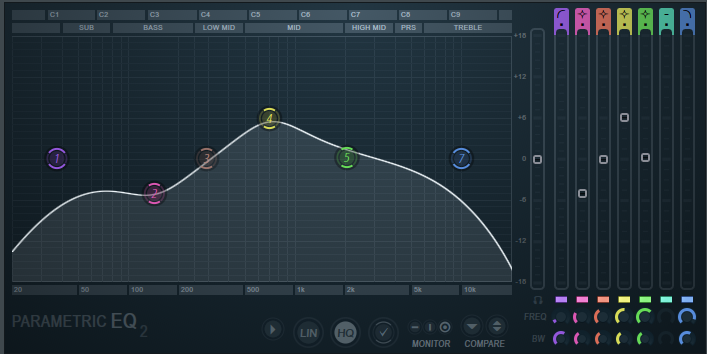

Sample rate 44100
x shape torch.Size([1, 1, 5000])


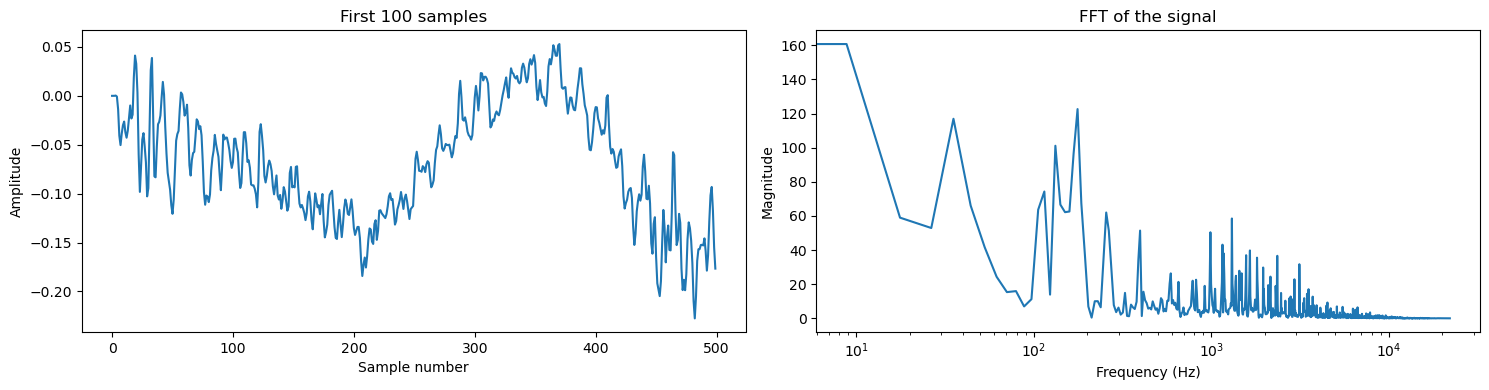

y_hat shape torch.Size([1, 1, 5000])


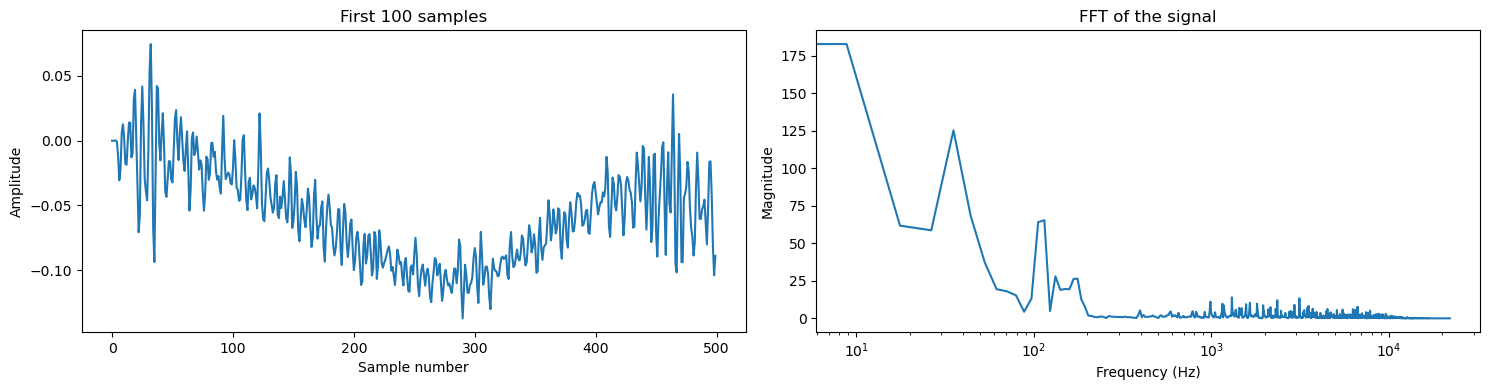

y shape torch.Size([1, 1, 5000])


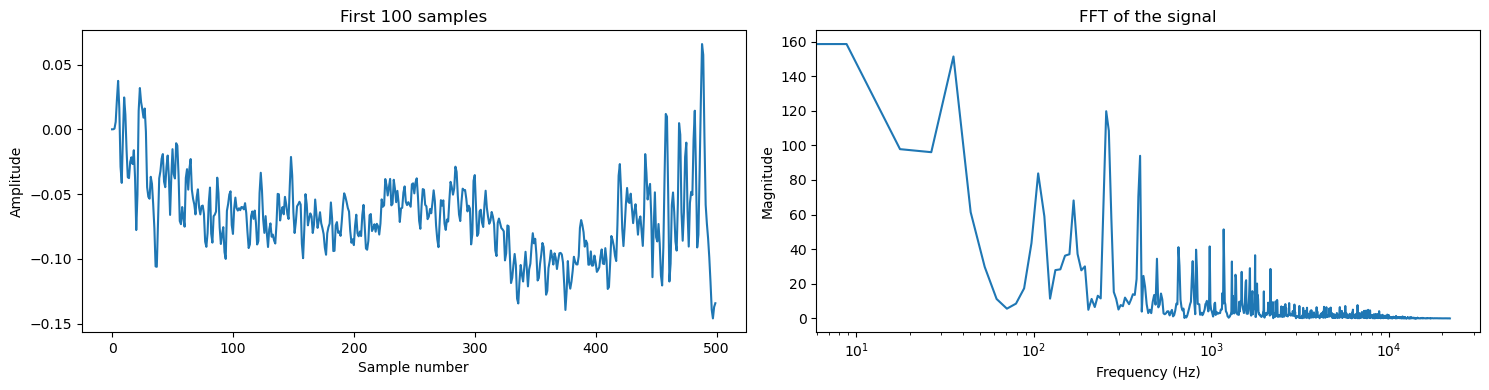

In [34]:
print("Sample rate",sr)
print("x shape",x.shape)
listen(x,sr)
show(x,sr)
print("y_hat shape",y_hat.shape)
listen(y_hat,sr)
show(y_hat,sr)
print("y shape",y.shape)
listen(y,sr)
show(y,sr)